In [82]:
library( DESeq2 )
library( ggplot2 )
library( biomaRt )
library( gplots )
library( genefilter )
library( RColorBrewer )
library( cluster )

In [77]:
species.db <- "mmusculus_gene_ensembl"
db.version <- "grcm38"
metadata.file <- "sample_sheet_Patrick_AdiposeMacs.txt"
data_dir = "output_data/"
# read in metadata
metadata <- read.csv("rmetadata.csv")
colnames(metadata) = c("id", "fname", "series")
metadata["worm"] = as.factor(1 - as.integer(metadata["series"] == "HFD") - 2*as.integer(metadata["series"] == "LFD"))
print(metadata)

            id                                          fname   series worm
1  16 HFD-pLex Patrick_AdiposeMacs_HFD-pLex_sample_0016.count HFD-pLex    1
2  17 HFD-pLex Patrick_AdiposeMacs_HFD-pLex_sample_0017.count HFD-pLex    1
3  20 HFD-pLex Patrick_AdiposeMacs_HFD-pLex_sample_0020.count HFD-pLex    1
4   11 HFD-SEA  Patrick_AdiposeMacs_HFD-SEA_sample_0011.count  HFD-SEA    1
5   12 HFD-SEA  Patrick_AdiposeMacs_HFD-SEA_sample_0012.count  HFD-SEA    1
6   13 HFD-SEA  Patrick_AdiposeMacs_HFD-SEA_sample_0013.count  HFD-SEA    1
7   14 HFD-SEA  Patrick_AdiposeMacs_HFD-SEA_sample_0014.count  HFD-SEA    1
8        6 HFD      Patrick_AdiposeMacs_HFD_sample_0006.count      HFD    0
9        7 HFD      Patrick_AdiposeMacs_HFD_sample_0007.count      HFD    0
10       2 LFD      Patrick_AdiposeMacs_LFD_sample_0002.count      LFD   -1


[1] "Running Contrast: series, HFD-SEA, HFD-pLex"


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Running Contrast: series, HFD-SEA, HFD"


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Running Contrast: series, HFD-pLex, HFD"


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Running Contrast: series, HFD, LFD"


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] "Running Contrast: worm, 1, 0"


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 5120 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


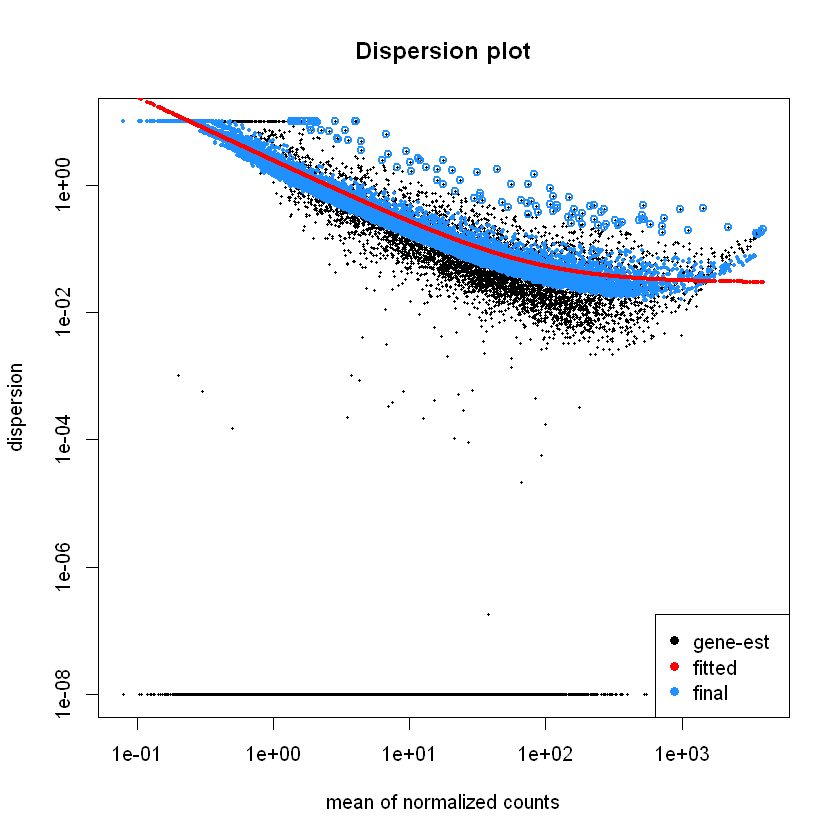

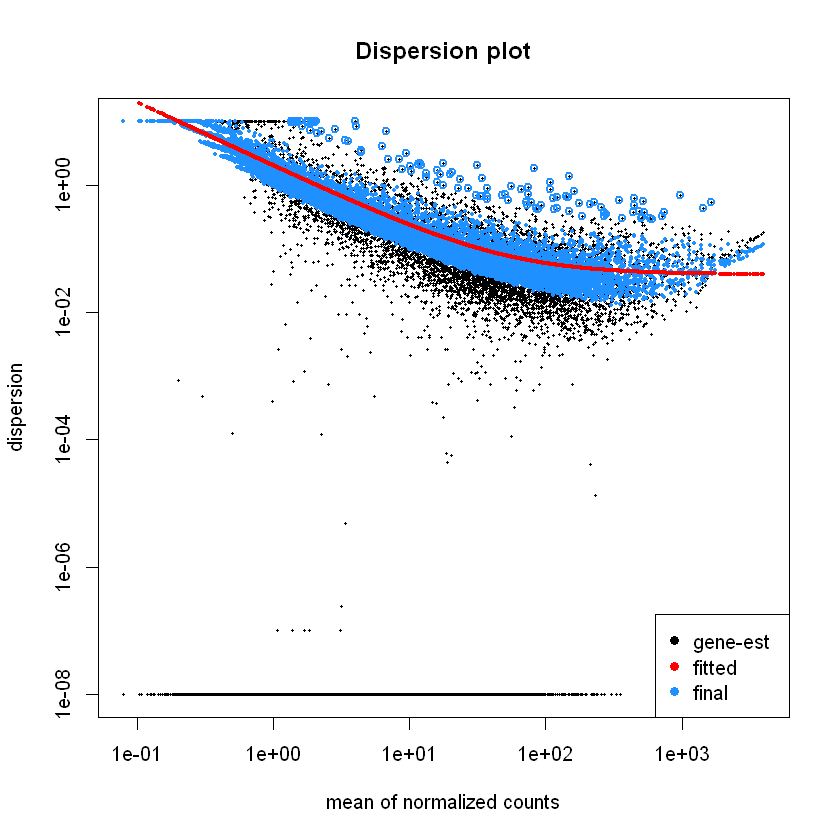

In [108]:
#fdr = false discovery rate
fdr <- 0.05
#lfc =  logarithmic fold change
lfc <- 0
contrasts <- list(c("series", "HFD-SEA", "HFD-pLex"),
                  c("series", "HFD-SEA", "HFD"),
                  c("series", "HFD-pLex", "HFD"),
                  c("series", "HFD", "LFD"),
                  c( "worm", 1, 0))
contrast_data = list()
for (fac in 1:length(contrasts)) {
    currcon <- contrasts[[fac]]
    print(paste("Running Contrast:", toString(currcon)))
    # generate object for DESeq2
    cds <- DESeqDataSetFromHTSeqCount( sampleTable = metadata,
                                       directory = "htseq_count",
                                       design = eval(parse(text=paste0("~",currcon[1]))))
    cds <- cds[ which( rowSums( counts( cds ) ) > 1 ), ]
    counts <- counts( cds )

    # NBM fit
    dds <- DESeq( cds )
    saveRDS( dds, file = paste0(data_dir, "deseq2_fit.RDS" ))
    plotDispEsts( dds, main = "Dispersion plot" )

    # create database for annotation before running loops
    mart <- useMart( "ENSEMBL_MART_ENSEMBL", dataset = species.db ) 
    # host = "www.biomart.org" )
    # host = paste0( db.version, ".ensembl.org" ) )
    filters <- c("external_gene_name")
    attributes <- c("external_gene_name", "name_1006")
    
    res <- results( dds, contrast = currcon )

    pdf( paste0(data_dir, currcon[1], "_", currcon[2], "_vs_", currcon[3], ".pdf" ) )
    DESeq2::plotMA( res, main = paste0( currcon[2], " vs ", currcon[3] ),
                  ylim = c( -5, 5 ), alpha = fdr )
    dev.off()

    # All differential genes
    all <- subset( res, padj < fdr )
    all <- all[ order( all$log2FoldChange, decreasing = T ), ]
    # all annotation
    all.genes <- rownames( all ) # rownames = ensembl gene ids
    all.genes <- data.frame( all.genes )
    colnames( all.genes )[1] <- "Ensembl"
    all.anno <- getBM( attributes = attributes, filters = filters, 
                     values = all.genes[,1],
                     mart = mart) # get all annotation based on ensembl ids

    all.anno = all.anno[all.anno$name_1006 != '',]
    
    # maintain un-annotated genes in BioMart, otherwise it will just get excluded in annotation data frame 
    # resulting in un-identified rows in the stats data frame

    all.single_anno <- merge( all.genes, all.anno, by.x = "Ensembl", by.y = "external_gene_name",
                      all.x = T )
    all.single_anno <- all.single_anno[ match( all.genes[,1], all.single_anno$Ensembl ), ] # reorder the annotation by LFC order
    
    all.anno.wStats <- data.frame( all.single_anno, all )
    contrast_data[[length(contrast_data)+1]] = list(cds, all.anno.wStats)
    write.table( all.anno.wStats, paste0(data_dir, currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_ALL.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )
    write.table( all.anno.wStats[,1:2], paste0(data_dir, currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_ALL_GeneList.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )

    # Upregulated genes only
    up.anno.wStats <- subset(all.anno.wStats, padj < fdr & log2FoldChange > lfc )
    up.anno.wStats <- up.anno.wStats[ order( up.anno.wStats$log2FoldChange, decreasing = T ), ]

    write.table( up.anno.wStats, paste0(data_dir, currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_up.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )
    write.table( up.anno.wStats[,1:2], paste0(data_dir, currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_up_GeneList.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )

    # Downregulated genes only
    down.anno.wStats <- subset(all.anno.wStats, padj < fdr & log2FoldChange < lfc )
    down.anno.wStats <- down.anno.wStats[ order( down.anno.wStats$log2FoldChange, decreasing = F ), ]

    write.table( down.anno.wStats, paste0(data_dir, currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_down.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )
    write.table( down.anno.wStats[,1:2], paste0(data_dir, currcon[2], "_vs_", currcon[3], "_FDR", fdr, "_down_GeneList.txt" ),
               sep="\t", quote=F, row.names=F, col.names=T )

}


In [112]:
contrast_data[[1]][[2]]

,Ensembl,name_1006,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1102,Cxcl13,chemokine activity,34.41487,3.305719,0.7154279,4.620618,3.825988e-06,4.023664e-04
624,Cd209f,mannose binding,148.04565,3.192862,0.9770974,3.267701,1.084247e-03,3.223789e-02
1137,Cxcl9,external side of plasma membrane,108.80434,3.110726,0.8033644,3.872124,1.078911e-04,5.948678e-03
3386,Serpinf1,negative regulation of gene expression,50.24711,2.590057,0.5866477,4.415014,1.010036e-05,8.962494e-04
2796,Pdcd1lg2,plasma membrane,37.27495,2.497314,0.5791445,4.312074,1.617303e-05,1.312095e-03
544,Ccl12,cellular response to organic cyclic compound,142.17735,2.411419,0.4004313,6.022055,1.722160e-09,6.985821e-07
604,Cd163,extracellular region,447.74865,2.407979,0.3130372,7.692309,1.445033e-14,2.735448e-11
2310,Lyz1,metabolic process,160.86505,2.322377,0.7394372,3.140736,1.685239e-03,4.294252e-02
2024,Il18bp,T-helper 1 type immune response,23.70426,2.322087,0.4724582,4.914905,8.882574e-07,1.237780e-04
1046,Cxcl12,induction of positive chemotaxis,37.49630,2.261381,0.5653176,4.000196,6.328993e-05,3.949709e-03


### Regularized transformation of read counts.
Take only genes with a max value >25th percentile of the per-gene max value.


In [79]:
rld = rlog( contrast_data[[1]][[1]], blind = T )
rld = assay( rld )
maxPerGene <- apply( rld, 1, max )
rld.25p = rld[ which( maxPerGene > quantile( maxPerGene )[2] ), ]


In [110]:
dim(rld.25p)
listAttributes(mart)

[1] 10676    10

name,description,page
ensembl_gene_id,Gene stable ID,feature_page
ensembl_gene_id_version,Gene stable ID version,feature_page
ensembl_transcript_id,Transcript stable ID,feature_page
ensembl_transcript_id_version,Transcript stable ID version,feature_page
ensembl_peptide_id,Protein stable ID,feature_page
ensembl_peptide_id_version,Protein stable ID version,feature_page
ensembl_exon_id,Exon stable ID,feature_page
description,Gene description,feature_page
chromosome_name,Chromosome/scaffold name,feature_page
start_position,Gene start (bp),feature_page


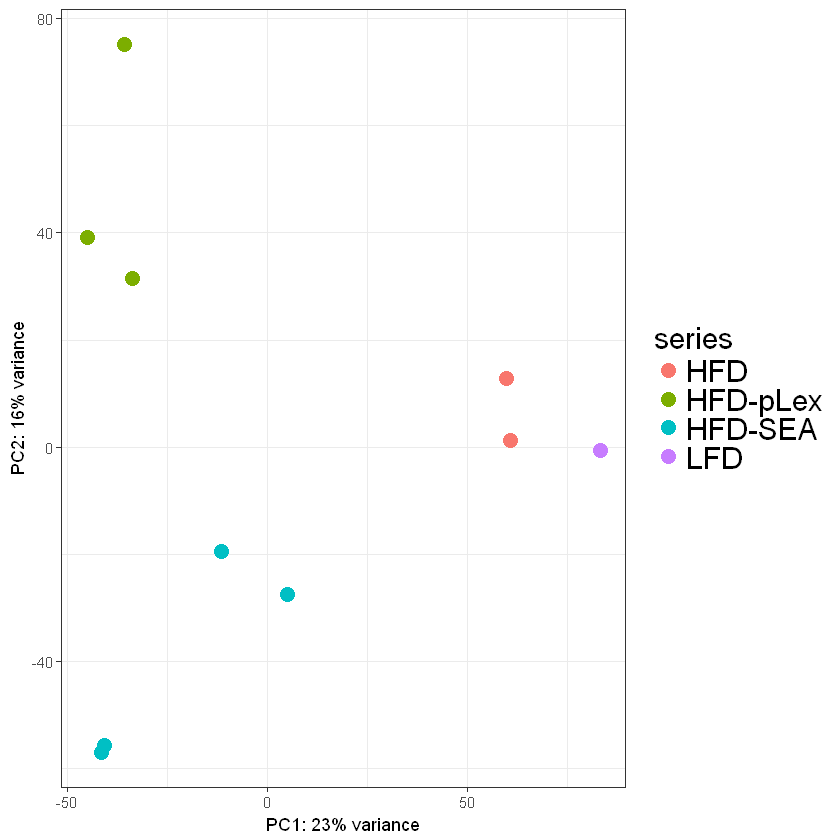

In [80]:
pca <- prcomp( t( rld.25p ), scale. = T )
percentVar <- round(( pca$sdev^2/sum(pca$sdev^2))*100  )
d <- data.frame( metadata, PC1 = pca$x[,1], PC2 = pca$x[,2] )
x= ggplot( d, aes( PC1, PC2, color = series) ) +
  theme_bw( ) +
  geom_point( size = 4 ) +
  scale_shape( solid = F ) +
  theme( legend.text = element_text( size = 18 ) ) +
  theme( legend.title = element_text( size = 18 ) ) +
  xlab( paste0( "PC1: ", percentVar[1], "% variance" ) ) +
  ylab( paste0( "PC2: ", percentVar[2], "% variance" ) ) 
print(x)

In [83]:
col1 <- colorRampPalette( brewer.pal( 9, "Reds" ) )
col2 <- colorRampPalette( rev( brewer.pal( 9, "Reds" ) ) )
col3 <- colorRampPalette( rev( brewer.pal( 11, "RdBu" ) ) )

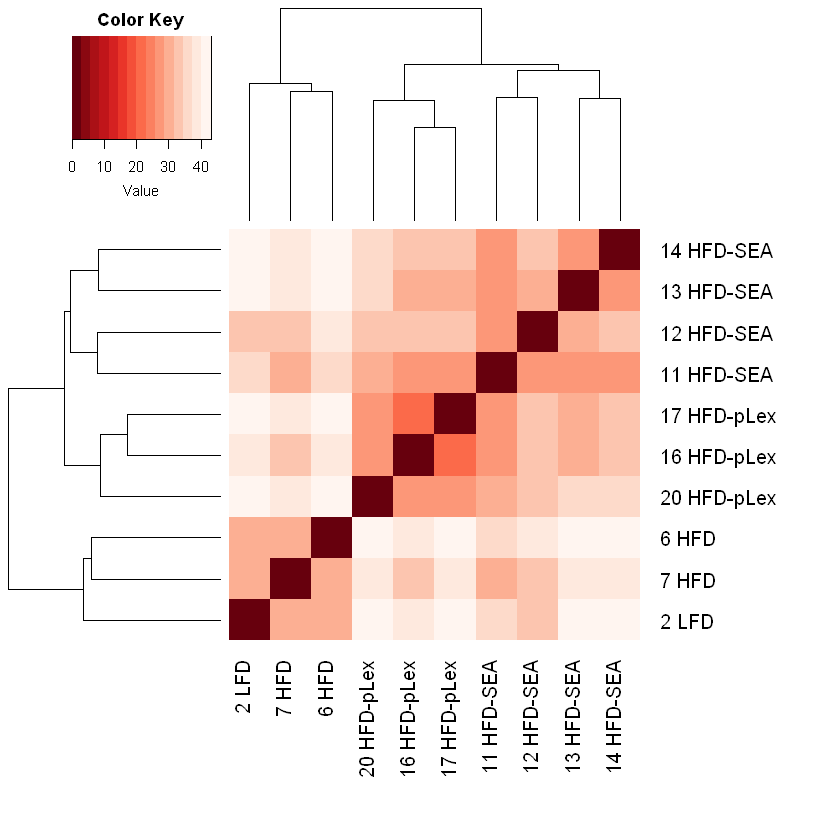

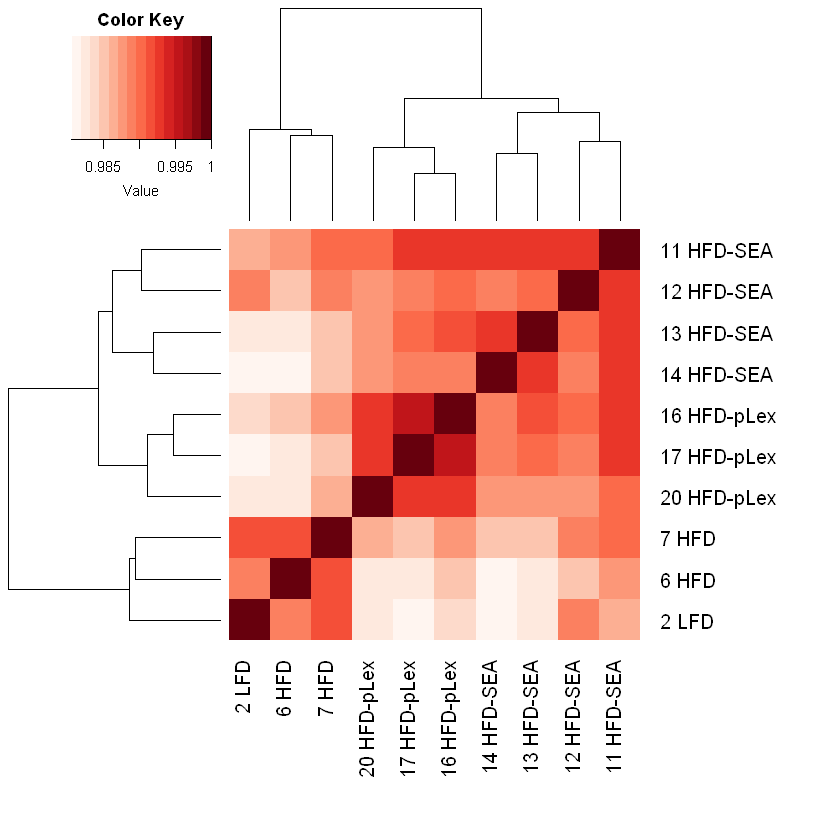

In [84]:
# Euclidean distance
macs.dist <- dist( t( rld.25p ), diag = T, upper = T, method = "euclidean" )
heatmap.2( as.matrix( macs.dist ), col = col2, trace="none", key=TRUE, density.info="none", margins = c( 10,10 ), dendrogram = "both" )

# Pearson correlation
macs.cor <- cor( rld.25p )
heatmap.2( macs.cor, col = col1, trace="none", key=TRUE, density.info="none",
           margins = c( 10,10 ), dendrogram = "both" )
